<center><h1>Get Data on NHS Waiting Times</h1></center>

In [8]:
import nhsdata
import numpy as np
import importlib
#importlib.reload(nhsdata)

### Get urls of all pages with the data

In [9]:
page_names = nhsdata.getAnEpages(verbose = 10)

Total of 13 pages found


### Get all xls file names

In [10]:
xls_file_names = nhsdata.get_xls_files(page_names, verbose = 10)

Total of 355 xls files found.


### Remove unwanted files

In [11]:
data = nhsdata.check_files(xls_file_names, verbose = 10)

Found 297 data sets.


### Get all Trust names

In [12]:
allNames = nhsdata.get_all_names(data[0], verbose = 0)

### Collect data from xls files

In [13]:
importlib.reload(nhsdata)
attendences, over4hours, periods = nhsdata.collectData(data, allNames, verbose = 0)


### Turn weekly data into monthly data

In [14]:
final_attendence, final_periods = nhsdata.sort_data(allNames, attendences, periods)
final_over4hours, final_periods = nhsdata.sort_data(allNames, over4hours, periods)
months = nhsdata.get_numpy_dates(final_periods)

### Final data tidy

- Turn all numbers as strings into ints
- Get rid of the nan line

In [15]:
final_attendence2 = nhsdata.tidy_data(final_attendence)
final_over4hours2 = nhsdata.tidy_data(final_over4hours)

### Save data

In [18]:
np.save("NHSwaiting.npy", [allNames, final_periods, final_attendence2, final_over4hours2])

## Check Plot

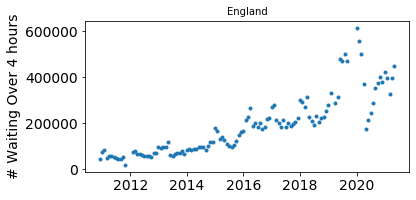

In [17]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=14)

i = 0

fig = matplotlib.pyplot.figure(figsize=(6,3))

ax1 = fig.add_subplot(111)
plt.title(allNames[i],size = 10)
mask = (final_over4hours[i,:] != '-')
waiting = final_over4hours[i,:][mask]
ax1.plot(months[mask], waiting,'.', lw=3)
ax1.set_ylabel("# Waiting Over 4 hours")
plt.tight_layout()
plt.show()